# Using `BlackMarblePy`

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/worldbank/blackmarblepy/blob/main/notebooks/blackmarblepy.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/worldbank/blackmarblepy/main?labpath=notebooks%2Fblackmarblepy.ipynb)

This Jupyter notebook provides a guided exploration of the [**BlackMarblePy**](https://pypi.org/project/blackmarblepy/) package, showcasing its capabilities for downloading, visualizing, and analyzing NASA Black Marble nighttime lights data. Through interactive examples, you'll learn how to:

- Download daily, monthly, and yearly data for specific dates, regions, or bounding boxes.
- Visualize downloaded data in various forms, including maps and  bar charts.
- Save visualizations and analysis results for further use.

## Requirements

Before downloading or extracting [NASA Black Marble data](https://blackmarble.gsfc.nasa.gov/), make sure the following requirements are met:

### 📦 Install `blackmarblepy`

To use this library, install the [blackmarblepy](https://pypi.org/project/blackmarblepy/) package. It is highly recommended to install it inside a [Python virtual environment](https://duckduckgo.com/?t=h_&q=Python+virtual+environment) to avoid dependency conflicts.

BlackMarblePy is available on [PyPI](https://pypi.org) as [blackmarblepy](https://pypi.org/project/blackmarblepy) and can installed using `pip`:


```shell
pip install blackmarblepy
```

In [1]:
# Install blackmarblepy and extras for examples
#!pip install "blackmarblepy[examples]"

In [2]:
import os
import datetime
import logging

import colorcet as cc
import contextily as cx
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, Title

from blackmarble import BlackMarble

from dotenv import load_dotenv

logging.getLogger("blackmarblepy").setLevel(logging.INFO)
load_dotenv()

%load_ext autoreload
%load_ext watermark
%autoreload 2
%watermark -v -u -n -p blackmarble

Last updated: Tue Jun 10 2025

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.3.0

blackmarble: 2025.6.3.dev3+g830d70c.d20250611



### ✅ Set Up NASA Earthdata Token

**BlackMarblePy** requires a valid, unexpired [NASA Earthdata](https://urs.earthdata.nasa.gov) **bearer token**, which you can retrieve from your [Earthdata profile](https://urs.earthdata.nasa.gov/profile).
For ease and security, we recommend [setting this as the BLACKMARBLE_TOKEN environment variable](https://duckduckgo.com/?q=how+to+set+environment+variable+linux+or+mac+or+windows) on your system.

1. Access [Earthdata Login](https://urs.earthdata.nasa.gov/profile). In case you haven't already, you must [register](https://urs.earthdata.nasa.gov/users/new).
    ```{figure} ../images/nasa_earthdata_profile.png
    ---
    height: 150px
    ---
2. Select **Generate Token**. If the token is expired or you are in need of one, click the **Generate Token** button. 
    ```{figure} ../images/nasa_earthdata_generate_token.png
    ---
    height: 400px
    ---
    ```
    
    ```{caution}
    Please be aware that the "Affiliation" information on your [Earthdata profile](https://urs.earthdata.nasa.gov/profile/edit) is mandatory. Without this information, the [NASA Earthdata token](https://urs.earthdata.nasa.gov/documentation) will be invalid. In case of a download error, try visiting the URL which is failing, as you may be prompted to grant permissions.
    
    ![](../images/nasa_earthdata_affiliations.png)
    ```
    
3. Use your token securely. We recommend [setting it as a secret or an environment variable](https://duckduckgo.com/?t=h_&q=environment+variable) rather than hardcoding it. For example, you can set the `BLACKMARBLE_TOKEN` environment variable to store your token safely in Unix-like systems:

    ```shell
    export BLACKMARBLE_TOKEN=<your_nasa_earthdata-token>
    ```

    ```{important}
    Using a secret token securely in Python code involves several practices to ensure the token is not exposed unintentionally. For instance, storing the secret token in an environment variable, in configuration files or using secret management services. In this example, we set up an environment variable.
    ```
    
    ```{seealso}
    - [Using Secrets Securely](https://worldbank.github.io/template/notebooks/nasa-apod.html)
    - [Best Practices froor Securing API Keys](https://rapidapi.com/guides/practices-api-keys)
    - [How to use Secrets in Google Colab](https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75)
    ```

 ```python
    # An environment variable can obfuscate to secure a secret
    import os
    
    bearer = os.getenv("BLACKMARBLE_TOKEN")
    ```
    
    ```python
    # If using Google Colab, use Secrets
    from google.colab import userdata
    
    bearer = userdata.get('BLACKMARBLE_TOKEN')
    ```

In [3]:
# Please the item 3 above
# If using Google Colab, you may use Secrets and uncomment below

bearer = os.getenv("BLACKMARBLE_TOKEN")

# If using Google Colab, you may use Secrets and uncomment below
# from google.colab import userdata
# os.environ["BLACKMARBLE_TOKEN"] = userdata.get('BLACKMARBLE_TOKEN')

### 🌍  Define Region of Interest

You must define a region of interest as a [`geopandas.GeoDataFrame`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html). This should represent the geographic area you want to extract data for.

For example, we obtain the polygon below from [GADM](https://gadm.org/download_country.html) for *Ghana*.

In [4]:
gdf = geopandas.read_file(
    "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_GHA_1.json.zip"
)
gdf.explore(tiles="CartoDB dark_matter")

```{figure} ../../images/favicon.ico
---
height: 0px
---
This map of Ghana displays the administrative boundaries as obtained from the Global Administrative Areas (GADM) database. The map highlights the regional divisions and key cities, providing a detailed geographic overview of the country. Data source: GADM, version 4.0.
```

## Examples

In this section, we will demonstrate how to use [BlackMarblePy](https://pypi.org/project/blackmarblepy/) to download and manipulate NASA Black Marble data.

[BlackMarblePy](https://pypi.org/project/blackmarblepy/) offers two main interfaces:
- A class-based interface ([`BlackMarble`](https://worldbank.github.io/blackmarblepy/api/blackmarble.html#blackmarble.core.BlackMarble)) that retains configuration details like the bearer token and output directory across multiple calls.
- A procedural API ([`bm_extract`](https://worldbank.github.io/blackmarblepy/api/blackmarble.html#blackmarble.extract.bm_extract), [`bm_raster`](https://worldbank.github.io/blackmarblepy/api/blackmarble.html#blackmarble.raster.bm_raster)) that provides the same functionality without requiring an instantiated object, making it convenient for one-off operations.

Both approaches give you flexible options depending on your workflow. We instantiate [`BlackMarble`](https://worldbank.github.io/blackmarblepy/api/blackmarble.html#blackmarble.core.BlackMarble) to use on the examples below. 

In [5]:
# Class-based interface example

# Initialize the BlackMarble interface.
bm = BlackMarble()

# Optional: explicitly configure all options
# bm = BlackMarble(
#     bearer="your_token_here",                     # NASA Earthdata bearer token (can also be set via env var)
#     check_all_tiles_exist=True,                   # Skip dates if any tile is missing
#     drop_values_by_quality_flag=[255],            # Mask out invalid data (e.g., fill value)
#     output_directory="data",                      # Directory to save outputs
#     output_skip_if_exists=True                    # Skip downloading if file already exists
# )

### Create raster of nighttime lights

In this section, we show examples of creating daily, monthly, and annual rasters of nighttime lights for the **Region of Interest** selected.


#### Daily

In [6]:
# Daily data: raster for February 5, 2021
VNP46A2_20210205 = bm.raster(
    gdf,
    product_id="VNP46A2",
    date_range="2021-02-05",
)
VNP46A2_20210205

OBTAINING MANIFEST...:   0%|          | 0/4 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading (16.4 MB)...:   0%|          | 0/4 [00:00<?, ?file/s]

PROCESSING TASKS | Downloading (16.4 MB)...:   0%|          | 0/4 [00:00<?, ?file/s]

  0%|          | 0.00/3.26M [00:00<?, ?B/s]

  0%|          | 0.00/4.41M [00:00<?, ?B/s]

  0%|          | 0.00/3.15M [00:00<?, ?B/s]

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading (16.4 MB)...:   0%|          | 0/4 [00:00<?, ?file/s]

COLLATING TILES | Processing...:   0%|          | 0/1 [00:00<?, ?date/s]

<xarray.Dataset> Size: 13MB
Dimensions:                            (x: 1071, y: 1544, time: 1)
Coordinates:
  * x                                  (x) float64 9kB -3.26 -3.256 ... 1.198
  * y                                  (y) float64 12kB 11.17 11.17 ... 4.744
  * time                               (time) datetime64[ns] 8B 2021-02-05
Data variables:
    Gap_Filled_DNB_BRDF-Corrected_NTL  (time, y, x) float64 13MB nan nan ... nan
Attributes: (12/42)
    AlgorithmType:                     b'SCI'
    DataResolution:                    b'Moderate'
    DayNightFlag:                      b'Day'
    EastBoundingCoord:                 0.0
    EndTime:                           b'2021-02-05 23:59:59.000'
    GranuleDayNightFlag:               b'Day'
    ...                                ...
    VerticalTileNumber:                b'07'
    WestBoundingCoord:                 -10.0
    AREA_OR_POINT:                     Area
    scale_factor:                      1.0
    add_offset:                        0.0
    _FillValue:                        nan

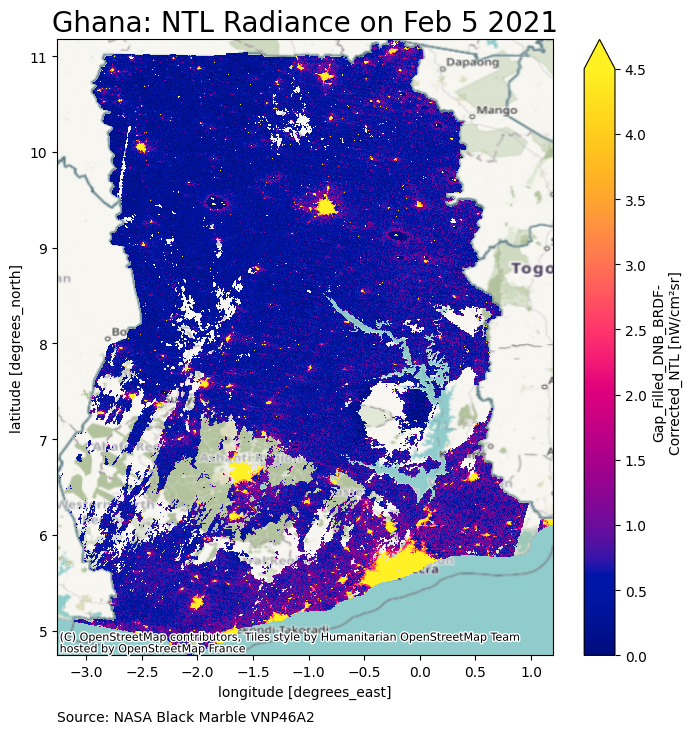

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

VNP46A2_20210205["Gap_Filled_DNB_BRDF-Corrected_NTL"].sel(
    time="2021-02-05"
).plot.pcolormesh(
    ax=ax,
    cmap=cc.cm.bmy,
    robust=True,
)
cx.add_basemap(ax, crs=gdf.crs.to_string())

ax.text(
    0,
    -0.1,
    "Source: NASA Black Marble VNP46A2",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)
ax.set_title("Ghana: NTL Radiance on Feb 5 2021", fontsize=20);

#### Monthly

In [8]:
# Monthly data: raster for October 2021
VNP46A3_202110 = bm.raster(
    gdf,
    product_id="VNP46A3",
    date_range="2021-10-01",
)
VNP46A3_202110

OBTAINING MANIFEST...:   0%|          | 0/4 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading (38.4 MB)...:   0%|          | 0/4 [00:00<?, ?file/s]

PROCESSING TASKS | Downloading (38.4 MB)...:   0%|          | 0/4 [00:00<?, ?file/s]

  0%|          | 0.00/10.6M [00:00<?, ?B/s]

  0%|          | 0.00/7.72M [00:00<?, ?B/s]

  0%|          | 0.00/8.64M [00:00<?, ?B/s]

  0%|          | 0.00/11.5M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading (38.4 MB)...:   0%|          | 0/4 [00:00<?, ?file/s]

COLLATING TILES | Processing...:   0%|          | 0/1 [00:00<?, ?date/s]

<xarray.Dataset> Size: 13MB
Dimensions:                        (x: 1071, y: 1544, time: 1)
Coordinates:
  * x                              (x) float64 9kB -3.26 -3.256 ... 1.194 1.198
  * y                              (y) float64 12kB 11.17 11.17 ... 4.748 4.744
  * time                           (time) datetime64[ns] 8B 2021-10-01
Data variables:
    NearNadir_Composite_Snow_Free  (time, y, x) float64 13MB nan nan ... nan nan
Attributes: (12/52)
    AlgorithmType:                     b'SCI'
    AlgorithmVersion:                  b'NPP_PR46A3 2.0.0'
    Conventions:                       b'CF-1.6'
    creator_email:                     b'modis-ops@lists.nasa.gov'
    creator_name:                      b'VIIRS Land SIPS Processing Group'
    creator_url:                       b'https://ladsweb.modaps.eosdis.nasa.gov'
    ...                                ...
    VerticalTileNumber:                b'08'
    WestBoundingCoord:                 0.0
    AREA_OR_POINT:                     Area
    scale_factor:                      1.0
    add_offset:                        0.0
    _FillValue:                        nan

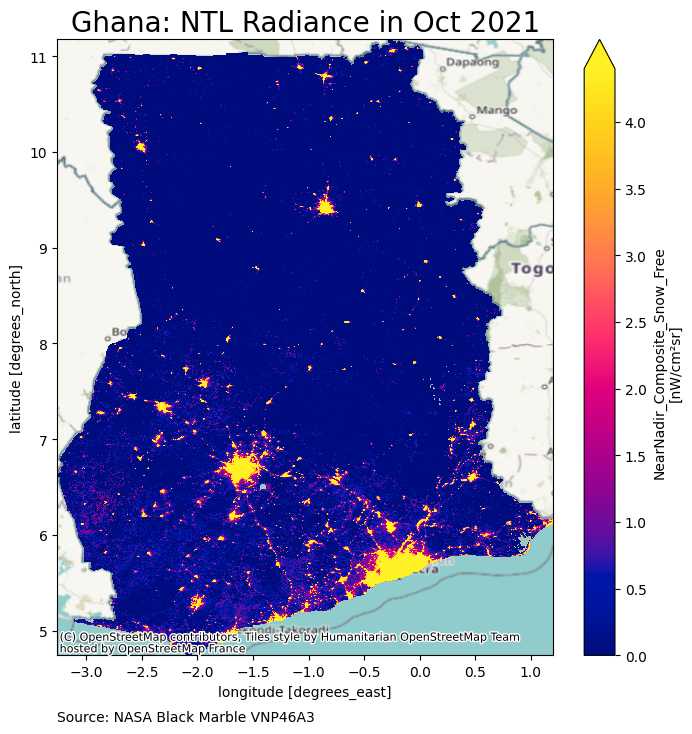

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))

VNP46A3_202110["NearNadir_Composite_Snow_Free"].sel(time="2021-10-01").plot.pcolormesh(
    ax=ax,
    cmap=cc.cm.bmy,
    robust=True,
)
cx.add_basemap(ax, crs=gdf.crs.to_string())

ax.text(
    0,
    -0.1,
    "Source: NASA Black Marble VNP46A3",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)
ax.set_title("Ghana: NTL Radiance in Oct 2021", fontsize=20);

#### Annual

In [10]:
# Annual data: raster for 2021
VNP46A4_2021 = bm.raster(
    gdf,
    product_id="VNP46A4",
    date_range="2021-01-01",
)
VNP46A4_2021

OBTAINING MANIFEST...:   0%|          | 0/4 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading (46.8 MB)...:   0%|          | 0/4 [00:00<?, ?file/s]

PROCESSING TASKS | Downloading (46.8 MB)...:   0%|          | 0/4 [00:00<?, ?file/s]

  0%|          | 0.00/9.66M [00:00<?, ?B/s]

  0%|          | 0.00/14.0M [00:00<?, ?B/s]

  0%|          | 0.00/9.37M [00:00<?, ?B/s]

  0%|          | 0.00/13.8M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading (46.8 MB)...:   0%|          | 0/4 [00:00<?, ?file/s]

COLLATING TILES | Processing...:   0%|          | 0/1 [00:00<?, ?date/s]

<xarray.Dataset> Size: 13MB
Dimensions:                        (x: 1071, y: 1544, time: 1)
Coordinates:
  * x                              (x) float64 9kB -3.26 -3.256 ... 1.194 1.198
  * y                              (y) float64 12kB 11.17 11.17 ... 4.748 4.744
  * time                           (time) datetime64[ns] 8B 2021-01-01
Data variables:
    NearNadir_Composite_Snow_Free  (time, y, x) float64 13MB nan nan ... nan nan
Attributes: (12/52)
    AlgorithmType:                     b'SCI'
    AlgorithmVersion:                  b'NPP_PR46A3 2.0.0'
    Conventions:                       b'CF-1.6'
    creator_email:                     b'modis-ops@lists.nasa.gov'
    creator_name:                      b'VIIRS Land SIPS Processing Group'
    creator_url:                       b'https://ladsweb.modaps.eosdis.nasa.gov'
    ...                                ...
    VerticalTileNumber:                b'07'
    WestBoundingCoord:                 0.0
    AREA_OR_POINT:                     Area
    scale_factor:                      1.0
    add_offset:                        0.0
    _FillValue:                        nan

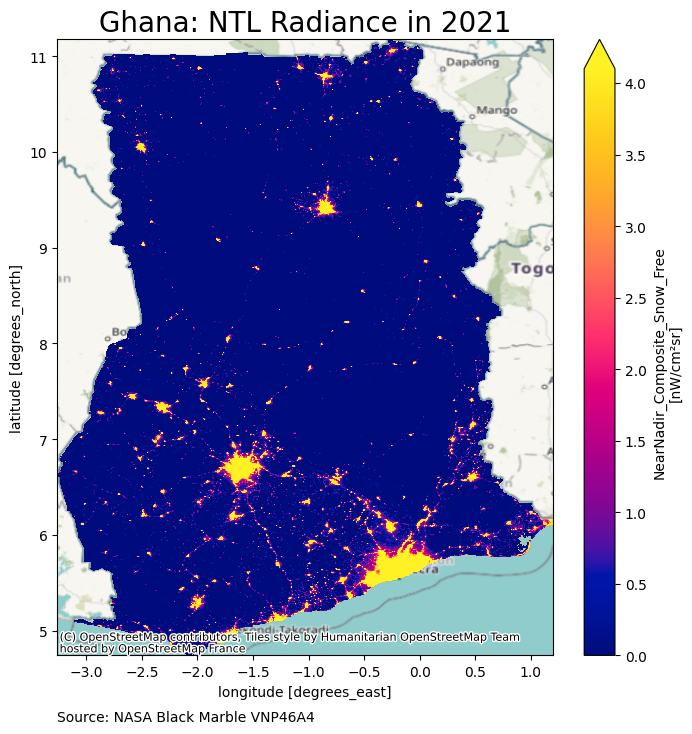

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

VNP46A4_2021["NearNadir_Composite_Snow_Free"].sel(time="2021-01-01").plot.pcolormesh(
    ax=ax,
    cmap=cc.cm.bmy,
    robust=True,
)
cx.add_basemap(ax, crs=gdf.crs.to_string())

ax.text(
    0,
    -0.1,
    "Source: NASA Black Marble VNP46A4",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)
ax.set_title("Ghana: NTL Radiance in 2021", fontsize=20);

### Create a raster stack of nighttime lights across multiple time periods

In this section, we illustrate how to retrieve and extract [NASA Black Marble](https://blackmarble.gsfc.nasa.gov) data for multiple time periods. The function will return a raster stack, where each raster band corresponds to a different date. The following code snippet provides examples of getting data across multiple days, months, and years. For each example, we define a date range using [`pd.date_range`](https://pandas.pydata.org/docs/reference/api/pandas.date_range.html).

In [12]:
# Raster stack of daily data
r_daily = bm.raster(
    gdf,
    product_id="VNP46A2",
    date_range=pd.date_range("2022-01-01", "2022-03-31", freq="D"),
)

OBTAINING MANIFEST...:   0%|          | 0/4 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading (1.3 GB)...:   0%|          | 0/360 [00:00<?, ?file/s]

PROCESSING TASKS | Downloading (1.3 GB)...:   0%|          | 0/360 [00:00<?, ?file/s]

  0%|          | 0.00/2.15M [00:00<?, ?B/s]

  0%|          | 0.00/2.44M [00:00<?, ?B/s]

  0%|          | 0.00/2.33M [00:00<?, ?B/s]

  0%|          | 0.00/2.25M [00:00<?, ?B/s]

  0%|          | 0.00/3.36M [00:00<?, ?B/s]

  0%|          | 0.00/2.90M [00:00<?, ?B/s]

  0%|          | 0.00/1.97M [00:00<?, ?B/s]

  0%|          | 0.00/1.84M [00:00<?, ?B/s]

  0%|          | 0.00/2.78M [00:00<?, ?B/s]

  0%|          | 0.00/3.51M [00:00<?, ?B/s]

  0%|          | 0.00/2.15M [00:00<?, ?B/s]

  0%|          | 0.00/1.70M [00:00<?, ?B/s]

  0%|          | 0.00/1.19M [00:00<?, ?B/s]

  0%|          | 0.00/1.50M [00:00<?, ?B/s]

  0%|          | 0.00/1.87M [00:00<?, ?B/s]

  0%|          | 0.00/2.48M [00:00<?, ?B/s]

  0%|          | 0.00/2.39M [00:00<?, ?B/s]

  0%|          | 0.00/2.62M [00:00<?, ?B/s]

  0%|          | 0.00/2.78M [00:00<?, ?B/s]

  0%|          | 0.00/2.12M [00:00<?, ?B/s]

  0%|          | 0.00/2.58M [00:00<?, ?B/s]

  0%|          | 0.00/2.74M [00:00<?, ?B/s]

  0%|          | 0.00/3.99M [00:00<?, ?B/s]

  0%|          | 0.00/3.01M [00:00<?, ?B/s]

  0%|          | 0.00/3.17M [00:00<?, ?B/s]

  0%|          | 0.00/3.54M [00:00<?, ?B/s]

  0%|          | 0.00/2.72M [00:00<?, ?B/s]

  0%|          | 0.00/3.00M [00:00<?, ?B/s]

  0%|          | 0.00/2.56M [00:00<?, ?B/s]

  0%|          | 0.00/2.74M [00:00<?, ?B/s]

  0%|          | 0.00/2.55M [00:00<?, ?B/s]

  0%|          | 0.00/2.88M [00:00<?, ?B/s]

  0%|          | 0.00/2.48M [00:00<?, ?B/s]

  0%|          | 0.00/2.74M [00:00<?, ?B/s]

  0%|          | 0.00/3.18M [00:00<?, ?B/s]

  0%|          | 0.00/2.75M [00:00<?, ?B/s]

  0%|          | 0.00/2.54M [00:00<?, ?B/s]

  0%|          | 0.00/3.40M [00:00<?, ?B/s]

  0%|          | 0.00/1.46M [00:00<?, ?B/s]

  0%|          | 0.00/2.57M [00:00<?, ?B/s]

  0%|          | 0.00/2.79M [00:00<?, ?B/s]

  0%|          | 0.00/2.31M [00:00<?, ?B/s]

  0%|          | 0.00/2.90M [00:00<?, ?B/s]

  0%|          | 0.00/2.53M [00:00<?, ?B/s]

  0%|          | 0.00/2.28M [00:00<?, ?B/s]

  0%|          | 0.00/2.45M [00:00<?, ?B/s]

  0%|          | 0.00/2.17M [00:00<?, ?B/s]

  0%|          | 0.00/2.11M [00:00<?, ?B/s]

  0%|          | 0.00/1.73M [00:00<?, ?B/s]

  0%|          | 0.00/2.16M [00:00<?, ?B/s]

  0%|          | 0.00/2.33M [00:00<?, ?B/s]

  0%|          | 0.00/2.87M [00:00<?, ?B/s]

  0%|          | 0.00/1.49M [00:00<?, ?B/s]

  0%|          | 0.00/2.18M [00:00<?, ?B/s]

  0%|          | 0.00/2.29M [00:00<?, ?B/s]

  0%|          | 0.00/2.18M [00:00<?, ?B/s]

  0%|          | 0.00/1.48M [00:00<?, ?B/s]

  0%|          | 0.00/2.10M [00:00<?, ?B/s]

  0%|          | 0.00/1.86M [00:00<?, ?B/s]

  0%|          | 0.00/1.39M [00:00<?, ?B/s]

  0%|          | 0.00/1.67M [00:00<?, ?B/s]

  0%|          | 0.00/3.66M [00:00<?, ?B/s]

  0%|          | 0.00/3.51M [00:00<?, ?B/s]

  0%|          | 0.00/3.98M [00:00<?, ?B/s]

  0%|          | 0.00/2.84M [00:00<?, ?B/s]

  0%|          | 0.00/3.03M [00:00<?, ?B/s]

  0%|          | 0.00/2.43M [00:00<?, ?B/s]

  0%|          | 0.00/2.81M [00:00<?, ?B/s]

  0%|          | 0.00/2.34M [00:00<?, ?B/s]

  0%|          | 0.00/3.71M [00:00<?, ?B/s]

  0%|          | 0.00/2.76M [00:00<?, ?B/s]

  0%|          | 0.00/3.89M [00:00<?, ?B/s]

  0%|          | 0.00/2.69M [00:00<?, ?B/s]

  0%|          | 0.00/1.90M [00:00<?, ?B/s]

  0%|          | 0.00/2.61M [00:00<?, ?B/s]

  0%|          | 0.00/3.48M [00:00<?, ?B/s]

  0%|          | 0.00/1.71M [00:00<?, ?B/s]

  0%|          | 0.00/1.81M [00:00<?, ?B/s]

  0%|          | 0.00/1.65M [00:00<?, ?B/s]

  0%|          | 0.00/2.38M [00:00<?, ?B/s]

  0%|          | 0.00/2.04M [00:00<?, ?B/s]

  0%|          | 0.00/1.19M [00:00<?, ?B/s]

  0%|          | 0.00/1.59M [00:00<?, ?B/s]

  0%|          | 0.00/1.40M [00:00<?, ?B/s]

  0%|          | 0.00/3.04M [00:00<?, ?B/s]

  0%|          | 0.00/1.93M [00:00<?, ?B/s]

  0%|          | 0.00/1.73M [00:00<?, ?B/s]

  0%|          | 0.00/1.51M [00:00<?, ?B/s]

  0%|          | 0.00/1.99M [00:00<?, ?B/s]

  0%|          | 0.00/4.28M [00:00<?, ?B/s]

  0%|          | 0.00/3.38M [00:00<?, ?B/s]

  0%|          | 0.00/2.19M [00:00<?, ?B/s]

  0%|          | 0.00/3.25M [00:00<?, ?B/s]

  0%|          | 0.00/3.36M [00:00<?, ?B/s]

  0%|          | 0.00/2.98M [00:00<?, ?B/s]

  0%|          | 0.00/3.34M [00:00<?, ?B/s]

  0%|          | 0.00/6.31M [00:00<?, ?B/s]

  0%|          | 0.00/4.25M [00:00<?, ?B/s]

  0%|          | 0.00/4.05M [00:00<?, ?B/s]

  0%|          | 0.00/3.58M [00:00<?, ?B/s]

  0%|          | 0.00/4.17M [00:00<?, ?B/s]

  0%|          | 0.00/4.89M [00:00<?, ?B/s]

  0%|          | 0.00/5.29M [00:00<?, ?B/s]

  0%|          | 0.00/6.97M [00:00<?, ?B/s]

  0%|          | 0.00/4.66M [00:00<?, ?B/s]

  0%|          | 0.00/4.26M [00:00<?, ?B/s]

  0%|          | 0.00/5.11M [00:00<?, ?B/s]

  0%|          | 0.00/5.86M [00:00<?, ?B/s]

  0%|          | 0.00/5.35M [00:00<?, ?B/s]

  0%|          | 0.00/6.15M [00:00<?, ?B/s]

  0%|          | 0.00/4.44M [00:00<?, ?B/s]

  0%|          | 0.00/4.36M [00:00<?, ?B/s]

  0%|          | 0.00/6.07M [00:00<?, ?B/s]

  0%|          | 0.00/5.72M [00:00<?, ?B/s]

  0%|          | 0.00/3.99M [00:00<?, ?B/s]

  0%|          | 0.00/4.06M [00:00<?, ?B/s]

  0%|          | 0.00/3.91M [00:00<?, ?B/s]

  0%|          | 0.00/3.62M [00:00<?, ?B/s]

  0%|          | 0.00/2.58M [00:00<?, ?B/s]

  0%|          | 0.00/3.64M [00:00<?, ?B/s]

  0%|          | 0.00/3.49M [00:00<?, ?B/s]

  0%|          | 0.00/5.12M [00:00<?, ?B/s]

  0%|          | 0.00/3.74M [00:00<?, ?B/s]

  0%|          | 0.00/4.84M [00:00<?, ?B/s]

  0%|          | 0.00/8.42M [00:00<?, ?B/s]

  0%|          | 0.00/6.73M [00:00<?, ?B/s]

  0%|          | 0.00/4.45M [00:00<?, ?B/s]

  0%|          | 0.00/3.70M [00:00<?, ?B/s]

  0%|          | 0.00/6.31M [00:00<?, ?B/s]

  0%|          | 0.00/3.46M [00:00<?, ?B/s]

  0%|          | 0.00/4.43M [00:00<?, ?B/s]

  0%|          | 0.00/3.57M [00:00<?, ?B/s]

  0%|          | 0.00/4.58M [00:00<?, ?B/s]

  0%|          | 0.00/4.39M [00:00<?, ?B/s]

  0%|          | 0.00/3.91M [00:00<?, ?B/s]

  0%|          | 0.00/4.09M [00:00<?, ?B/s]

  0%|          | 0.00/4.07M [00:00<?, ?B/s]

  0%|          | 0.00/6.67M [00:00<?, ?B/s]

  0%|          | 0.00/3.65M [00:00<?, ?B/s]

  0%|          | 0.00/6.77M [00:00<?, ?B/s]

  0%|          | 0.00/4.16M [00:00<?, ?B/s]

  0%|          | 0.00/4.18M [00:00<?, ?B/s]

  0%|          | 0.00/4.31M [00:00<?, ?B/s]

  0%|          | 0.00/4.71M [00:00<?, ?B/s]

  0%|          | 0.00/4.81M [00:00<?, ?B/s]

  0%|          | 0.00/4.09M [00:00<?, ?B/s]

  0%|          | 0.00/4.11M [00:00<?, ?B/s]

  0%|          | 0.00/4.30M [00:00<?, ?B/s]

  0%|          | 0.00/4.79M [00:00<?, ?B/s]

  0%|          | 0.00/4.31M [00:00<?, ?B/s]

  0%|          | 0.00/4.02M [00:00<?, ?B/s]

  0%|          | 0.00/7.18M [00:00<?, ?B/s]

  0%|          | 0.00/5.64M [00:00<?, ?B/s]

  0%|          | 0.00/6.76M [00:00<?, ?B/s]

  0%|          | 0.00/2.09M [00:00<?, ?B/s]

  0%|          | 0.00/5.70M [00:00<?, ?B/s]

  0%|          | 0.00/5.53M [00:00<?, ?B/s]

  0%|          | 0.00/5.80M [00:00<?, ?B/s]

  0%|          | 0.00/4.43M [00:00<?, ?B/s]

  0%|          | 0.00/3.97M [00:00<?, ?B/s]

  0%|          | 0.00/5.05M [00:00<?, ?B/s]

  0%|          | 0.00/3.46M [00:00<?, ?B/s]

  0%|          | 0.00/4.68M [00:00<?, ?B/s]

  0%|          | 0.00/4.15M [00:00<?, ?B/s]

  0%|          | 0.00/4.36M [00:00<?, ?B/s]

  0%|          | 0.00/4.49M [00:00<?, ?B/s]

  0%|          | 0.00/4.10M [00:00<?, ?B/s]

  0%|          | 0.00/5.16M [00:00<?, ?B/s]

  0%|          | 0.00/4.58M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

  0%|          | 0.00/4.49M [00:00<?, ?B/s]

  0%|          | 0.00/6.08M [00:00<?, ?B/s]

  0%|          | 0.00/4.82M [00:00<?, ?B/s]

  0%|          | 0.00/4.12M [00:00<?, ?B/s]

  0%|          | 0.00/3.21M [00:00<?, ?B/s]

  0%|          | 0.00/4.40M [00:00<?, ?B/s]

  0%|          | 0.00/4.70M [00:00<?, ?B/s]

  0%|          | 0.00/4.86M [00:00<?, ?B/s]

  0%|          | 0.00/4.27M [00:00<?, ?B/s]

  0%|          | 0.00/3.98M [00:00<?, ?B/s]

  0%|          | 0.00/2.20M [00:00<?, ?B/s]

  0%|          | 0.00/2.29M [00:00<?, ?B/s]

  0%|          | 0.00/2.26M [00:00<?, ?B/s]

  0%|          | 0.00/1.69M [00:00<?, ?B/s]

  0%|          | 0.00/2.32M [00:00<?, ?B/s]

  0%|          | 0.00/2.43M [00:00<?, ?B/s]

  0%|          | 0.00/2.00M [00:00<?, ?B/s]

  0%|          | 0.00/2.99M [00:00<?, ?B/s]

  0%|          | 0.00/3.13M [00:00<?, ?B/s]

  0%|          | 0.00/2.84M [00:00<?, ?B/s]

  0%|          | 0.00/2.57M [00:00<?, ?B/s]

  0%|          | 0.00/3.66M [00:00<?, ?B/s]

  0%|          | 0.00/2.79M [00:00<?, ?B/s]

  0%|          | 0.00/2.90M [00:00<?, ?B/s]

  0%|          | 0.00/2.82M [00:00<?, ?B/s]

  0%|          | 0.00/2.30M [00:00<?, ?B/s]

  0%|          | 0.00/1.68M [00:00<?, ?B/s]

  0%|          | 0.00/1.56M [00:00<?, ?B/s]

  0%|          | 0.00/2.75M [00:00<?, ?B/s]

  0%|          | 0.00/1.72M [00:00<?, ?B/s]

  0%|          | 0.00/1.71M [00:00<?, ?B/s]

  0%|          | 0.00/1.49M [00:00<?, ?B/s]

  0%|          | 0.00/2.44M [00:00<?, ?B/s]

  0%|          | 0.00/1.42M [00:00<?, ?B/s]

  0%|          | 0.00/2.98M [00:00<?, ?B/s]

  0%|          | 0.00/2.48M [00:00<?, ?B/s]

  0%|          | 0.00/2.88M [00:00<?, ?B/s]

  0%|          | 0.00/2.59M [00:00<?, ?B/s]

  0%|          | 0.00/2.02M [00:00<?, ?B/s]

  0%|          | 0.00/1.76M [00:00<?, ?B/s]

  0%|          | 0.00/2.32M [00:00<?, ?B/s]

  0%|          | 0.00/2.20M [00:00<?, ?B/s]

  0%|          | 0.00/2.12M [00:00<?, ?B/s]

  0%|          | 0.00/3.43M [00:00<?, ?B/s]

  0%|          | 0.00/3.49M [00:00<?, ?B/s]

  0%|          | 0.00/2.81M [00:00<?, ?B/s]

  0%|          | 0.00/2.42M [00:00<?, ?B/s]

  0%|          | 0.00/2.44M [00:00<?, ?B/s]

  0%|          | 0.00/2.64M [00:00<?, ?B/s]

  0%|          | 0.00/2.82M [00:00<?, ?B/s]

  0%|          | 0.00/3.03M [00:00<?, ?B/s]

  0%|          | 0.00/3.71M [00:00<?, ?B/s]

  0%|          | 0.00/3.11M [00:00<?, ?B/s]

  0%|          | 0.00/2.98M [00:00<?, ?B/s]

  0%|          | 0.00/2.39M [00:00<?, ?B/s]

  0%|          | 0.00/2.51M [00:00<?, ?B/s]

  0%|          | 0.00/1.86M [00:00<?, ?B/s]

  0%|          | 0.00/1.79M [00:00<?, ?B/s]

  0%|          | 0.00/1.52M [00:00<?, ?B/s]

  0%|          | 0.00/2.23M [00:00<?, ?B/s]

  0%|          | 0.00/1.88M [00:00<?, ?B/s]

  0%|          | 0.00/1.86M [00:00<?, ?B/s]

  0%|          | 0.00/1.80M [00:00<?, ?B/s]

  0%|          | 0.00/2.96M [00:00<?, ?B/s]

  0%|          | 0.00/2.18M [00:00<?, ?B/s]

  0%|          | 0.00/2.31M [00:00<?, ?B/s]

  0%|          | 0.00/1.42M [00:00<?, ?B/s]

  0%|          | 0.00/1.91M [00:00<?, ?B/s]

  0%|          | 0.00/2.18M [00:00<?, ?B/s]

  0%|          | 0.00/3.40M [00:00<?, ?B/s]

  0%|          | 0.00/3.42M [00:00<?, ?B/s]

  0%|          | 0.00/2.99M [00:00<?, ?B/s]

  0%|          | 0.00/3.39M [00:00<?, ?B/s]

  0%|          | 0.00/2.03M [00:00<?, ?B/s]

  0%|          | 0.00/2.75M [00:00<?, ?B/s]

  0%|          | 0.00/2.83M [00:00<?, ?B/s]

  0%|          | 0.00/3.04M [00:00<?, ?B/s]

  0%|          | 0.00/2.97M [00:00<?, ?B/s]

  0%|          | 0.00/3.38M [00:00<?, ?B/s]

  0%|          | 0.00/3.54M [00:00<?, ?B/s]

  0%|          | 0.00/1.63M [00:00<?, ?B/s]

  0%|          | 0.00/3.05M [00:00<?, ?B/s]

  0%|          | 0.00/2.25M [00:00<?, ?B/s]

  0%|          | 0.00/3.51M [00:00<?, ?B/s]

  0%|          | 0.00/2.85M [00:00<?, ?B/s]

  0%|          | 0.00/3.36M [00:00<?, ?B/s]

  0%|          | 0.00/2.79M [00:00<?, ?B/s]

  0%|          | 0.00/2.73M [00:00<?, ?B/s]

  0%|          | 0.00/2.77M [00:00<?, ?B/s]

  0%|          | 0.00/1.84M [00:00<?, ?B/s]

  0%|          | 0.00/1.37M [00:00<?, ?B/s]

  0%|          | 0.00/1.41M [00:00<?, ?B/s]

  0%|          | 0.00/1.76M [00:00<?, ?B/s]

  0%|          | 0.00/2.09M [00:00<?, ?B/s]

  0%|          | 0.00/1.99M [00:00<?, ?B/s]

[2025-06-10 20:53:58] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A2.A2022014.h18v08.001.2022022094649.h5


  0%|          | 0.00/2.09M [00:00<?, ?B/s]

  0%|          | 0.00/1.71M [00:00<?, ?B/s]

  0%|          | 0.00/2.19M [00:00<?, ?B/s]

  0%|          | 0.00/2.40M [00:00<?, ?B/s]

  0%|          | 0.00/3.23M [00:00<?, ?B/s]

  0%|          | 0.00/3.51M [00:00<?, ?B/s]

  0%|          | 0.00/3.94M [00:00<?, ?B/s]

  0%|          | 0.00/3.83M [00:00<?, ?B/s]

  0%|          | 0.00/4.50M [00:00<?, ?B/s]

  0%|          | 0.00/6.14M [00:00<?, ?B/s]

  0%|          | 0.00/2.46M [00:00<?, ?B/s]

  0%|          | 0.00/1.72M [00:00<?, ?B/s]

  0%|          | 0.00/7.52M [00:00<?, ?B/s]

  0%|          | 0.00/3.98M [00:00<?, ?B/s]

  0%|          | 0.00/4.37M [00:00<?, ?B/s]

  0%|          | 0.00/4.80M [00:00<?, ?B/s]

  0%|          | 0.00/3.71M [00:00<?, ?B/s]

  0%|          | 0.00/4.15M [00:00<?, ?B/s]

  0%|          | 0.00/3.61M [00:00<?, ?B/s]

  0%|          | 0.00/5.08M [00:00<?, ?B/s]

  0%|          | 0.00/4.86M [00:00<?, ?B/s]

  0%|          | 0.00/4.34M [00:00<?, ?B/s]

  0%|          | 0.00/6.80M [00:00<?, ?B/s]

  0%|          | 0.00/6.60M [00:00<?, ?B/s]

  0%|          | 0.00/2.01M [00:00<?, ?B/s]

  0%|          | 0.00/4.49M [00:00<?, ?B/s]

  0%|          | 0.00/5.63M [00:00<?, ?B/s]

  0%|          | 0.00/5.66M [00:00<?, ?B/s]

  0%|          | 0.00/5.84M [00:00<?, ?B/s]

  0%|          | 0.00/4.00M [00:00<?, ?B/s]

  0%|          | 0.00/4.95M [00:00<?, ?B/s]

  0%|          | 0.00/4.37M [00:00<?, ?B/s]

  0%|          | 0.00/4.23M [00:00<?, ?B/s]

  0%|          | 0.00/3.98M [00:00<?, ?B/s]

  0%|          | 0.00/4.93M [00:00<?, ?B/s]

  0%|          | 0.00/3.84M [00:00<?, ?B/s]

  0%|          | 0.00/5.83M [00:00<?, ?B/s]

  0%|          | 0.00/4.81M [00:00<?, ?B/s]

  0%|          | 0.00/5.31M [00:00<?, ?B/s]

[2025-06-10 20:54:07] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A2.A2022030.h18v07.001.2022047185519.h5


  0%|          | 0.00/6.27M [00:00<?, ?B/s]

  0%|          | 0.00/4.78M [00:00<?, ?B/s]

  0%|          | 0.00/3.39M [00:00<?, ?B/s]

  0%|          | 0.00/6.25M [00:00<?, ?B/s]

  0%|          | 0.00/3.26M [00:00<?, ?B/s]

  0%|          | 0.00/2.91M [00:00<?, ?B/s]

  0%|          | 0.00/2.72M [00:00<?, ?B/s]

  0%|          | 0.00/4.01M [00:00<?, ?B/s]

  0%|          | 0.00/4.45M [00:00<?, ?B/s]

  0%|          | 0.00/3.49M [00:00<?, ?B/s]

  0%|          | 0.00/4.67M [00:00<?, ?B/s]

  0%|          | 0.00/3.24M [00:00<?, ?B/s]

  0%|          | 0.00/5.08M [00:00<?, ?B/s]

  0%|          | 0.00/3.56M [00:00<?, ?B/s]

  0%|          | 0.00/6.75M [00:00<?, ?B/s]

  0%|          | 0.00/6.96M [00:00<?, ?B/s]

  0%|          | 0.00/7.26M [00:00<?, ?B/s]

  0%|          | 0.00/7.20M [00:00<?, ?B/s]

  0%|          | 0.00/6.57M [00:00<?, ?B/s]

  0%|          | 0.00/4.11M [00:00<?, ?B/s]

  0%|          | 0.00/4.29M [00:00<?, ?B/s]

  0%|          | 0.00/5.05M [00:00<?, ?B/s]

  0%|          | 0.00/4.00M [00:00<?, ?B/s]

  0%|          | 0.00/3.77M [00:00<?, ?B/s]

  0%|          | 0.00/5.44M [00:00<?, ?B/s]

  0%|          | 0.00/5.15M [00:00<?, ?B/s]

  0%|          | 0.00/4.12M [00:00<?, ?B/s]

  0%|          | 0.00/4.45M [00:00<?, ?B/s]

  0%|          | 0.00/6.17M [00:00<?, ?B/s]

  0%|          | 0.00/8.34M [00:00<?, ?B/s]

  0%|          | 0.00/5.26M [00:00<?, ?B/s]

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

  0%|          | 0.00/5.94M [00:00<?, ?B/s]

[2025-06-10 20:54:15] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A2.A2022013.h18v07.001.2022021102621.h5


  0%|          | 0.00/5.31M [00:00<?, ?B/s]

  0%|          | 0.00/5.52M [00:00<?, ?B/s]

  0%|          | 0.00/4.06M [00:00<?, ?B/s]

  0%|          | 0.00/3.78M [00:00<?, ?B/s]

  0%|          | 0.00/4.87M [00:00<?, ?B/s]

  0%|          | 0.00/3.17M [00:00<?, ?B/s]

  0%|          | 0.00/4.35M [00:00<?, ?B/s]

  0%|          | 0.00/3.90M [00:00<?, ?B/s]

  0%|          | 0.00/4.33M [00:00<?, ?B/s]

  0%|          | 0.00/5.53M [00:00<?, ?B/s]

  0%|          | 0.00/5.99M [00:00<?, ?B/s]

  0%|          | 0.00/5.45M [00:00<?, ?B/s]

  0%|          | 0.00/5.07M [00:00<?, ?B/s]

  0%|          | 0.00/3.55M [00:00<?, ?B/s]

  0%|          | 0.00/5.77M [00:00<?, ?B/s]

  0%|          | 0.00/4.63M [00:00<?, ?B/s]

  0%|          | 0.00/4.27M [00:00<?, ?B/s]

  0%|          | 0.00/3.78M [00:00<?, ?B/s]

  0%|          | 0.00/4.30M [00:00<?, ?B/s]

  0%|          | 0.00/5.25M [00:00<?, ?B/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

  0%|          | 0.00/4.75M [00:00<?, ?B/s]

  0%|          | 0.00/3.84M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading (1.3 GB)...:   0%|          | 0/360 [00:00<?, ?file/s]

COLLATING TILES | Processing...:   0%|          | 0/90 [00:00<?, ?date/s]

In [13]:
r_daily

<xarray.Dataset> Size: 1GB
Dimensions:                            (x: 1071, y: 1544, time: 90)
Coordinates:
  * x                                  (x) float64 9kB -3.26 -3.256 ... 1.198
  * y                                  (y) float64 12kB 11.17 11.17 ... 4.744
  * time                               (time) datetime64[ns] 720B 2022-01-01 ...
Data variables:
    Gap_Filled_DNB_BRDF-Corrected_NTL  (time, y, x) float64 1GB nan nan ... nan
Attributes: (12/32)
    AlgorithmType:                     b'SCI'
    DataResolution:                    b'Moderate'
    DayNightFlag:                      b'Day'
    EastBoundingCoord:                 0.0
    GranuleDayNightFlag:               b'Day'
    GRingPointLatitude:                [ 0. 10. 10.  0.]
    ...                                ...
    VerticalTileNumber:                b'08'
    WestBoundingCoord:                 -10.0
    AREA_OR_POINT:                     Area
    scale_factor:                      1.0
    add_offset:                        0.0
    _FillValue:                        nan

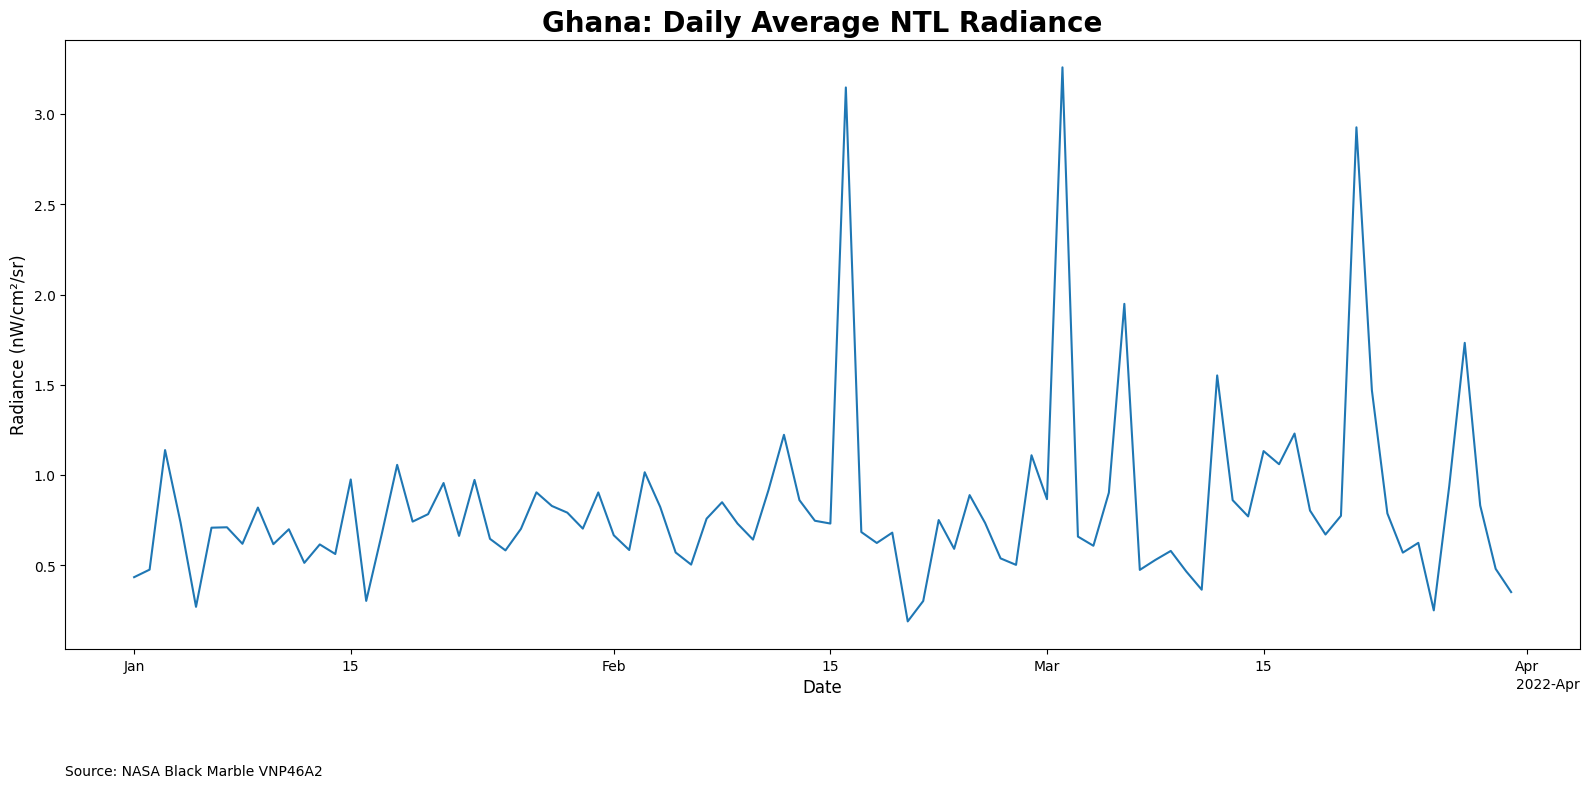

In [14]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the mean NTL radiance over the dimensions x and y
r_daily["Gap_Filled_DNB_BRDF-Corrected_NTL"].mean(dim=["x", "y"]).plot(ax=ax)

# Add the data source text
ax.text(
    0,
    -0.2,
    "Source: NASA Black Marble VNP46A2",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)

# Set the title with appropriate fontsize
ax.set_title("Ghana: Daily Average NTL Radiance", fontsize=20, weight="bold")

# Add labels to the axes
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Radiance (nW/cm²/sr)", fontsize=12)

# Adjust layout for better spacing
fig.tight_layout()

# Show the plot
plt.show()

```{figure} ../../images/favicon.ico
---
height: 0px
---
This figures describes the daily average nighttime lights radiance data plotted over time. The data reflects fluctuations in radiance levels due to varying cloud cover, affecting the accuracy of the measurements
```

In [15]:
# Raster stack of monthly data
r_monthly = bm.raster(
    gdf,
    product_id="VNP46A3",
    date_range=pd.date_range("2022-01-01", "2022-12-31", freq="MS"),
)

OBTAINING MANIFEST...:   0%|          | 0/4 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading (446.0 MB)...:   0%|          | 0/48 [00:00<?, ?file/s]

PROCESSING TASKS | Downloading (446.0 MB)...:   0%|          | 0/48 [00:00<?, ?file/s]

  0%|          | 0.00/10.6M [00:00<?, ?B/s]

  0%|          | 0.00/12.5M [00:00<?, ?B/s]

  0%|          | 0.00/8.79M [00:00<?, ?B/s]

  0%|          | 0.00/10.2M [00:00<?, ?B/s]

  0%|          | 0.00/9.15M [00:00<?, ?B/s]

  0%|          | 0.00/10.6M [00:00<?, ?B/s]

  0%|          | 0.00/10.2M [00:00<?, ?B/s]

  0%|          | 0.00/8.50M [00:00<?, ?B/s]

  0%|          | 0.00/9.44M [00:00<?, ?B/s]

  0%|          | 0.00/9.73M [00:00<?, ?B/s]

  0%|          | 0.00/11.2M [00:00<?, ?B/s]

  0%|          | 0.00/7.41M [00:00<?, ?B/s]

  0%|          | 0.00/8.26M [00:00<?, ?B/s]

  0%|          | 0.00/7.80M [00:00<?, ?B/s]

  0%|          | 0.00/9.68M [00:00<?, ?B/s]

  0%|          | 0.00/8.28M [00:00<?, ?B/s]

  0%|          | 0.00/7.41M [00:00<?, ?B/s]

  0%|          | 0.00/8.42M [00:00<?, ?B/s]

  0%|          | 0.00/8.50M [00:00<?, ?B/s]

  0%|          | 0.00/9.14M [00:00<?, ?B/s]

  0%|          | 0.00/7.82M [00:00<?, ?B/s]

  0%|          | 0.00/8.44M [00:00<?, ?B/s]

  0%|          | 0.00/10.0M [00:00<?, ?B/s]

  0%|          | 0.00/7.99M [00:00<?, ?B/s]

[2025-06-10 20:56:35] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A3.A2022274.h18v07.001.2022312193837.h5


  0%|          | 0.00/7.62M [00:00<?, ?B/s]

  0%|          | 0.00/7.53M [00:00<?, ?B/s]

  0%|          | 0.00/7.39M [00:00<?, ?B/s]

  0%|          | 0.00/7.96M [00:00<?, ?B/s]

  0%|          | 0.00/7.79M [00:00<?, ?B/s]

  0%|          | 0.00/8.05M [00:00<?, ?B/s]

  0%|          | 0.00/11.7M [00:00<?, ?B/s]

  0%|          | 0.00/9.35M [00:00<?, ?B/s]

  0%|          | 0.00/9.00M [00:00<?, ?B/s]

  0%|          | 0.00/8.50M [00:00<?, ?B/s]

  0%|          | 0.00/11.5M [00:00<?, ?B/s]

  0%|          | 0.00/9.13M [00:00<?, ?B/s]

  0%|          | 0.00/9.49M [00:00<?, ?B/s]

[2025-06-10 20:56:43] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A3.A2022305.h18v08.001.2022342132552.h5


  0%|          | 0.00/9.48M [00:00<?, ?B/s]

  0%|          | 0.00/9.58M [00:00<?, ?B/s]

[2025-06-10 20:56:44] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A3.A2022121.h18v08.001.2022159105232.h5


  0%|          | 0.00/11.5M [00:00<?, ?B/s]

  0%|          | 0.00/10.4M [00:00<?, ?B/s]

  0%|          | 0.00/8.64M [00:00<?, ?B/s]

  0%|          | 0.00/11.4M [00:00<?, ?B/s]

  0%|          | 0.00/9.06M [00:00<?, ?B/s]

  0%|          | 0.00/11.5M [00:00<?, ?B/s]

  0%|          | 0.00/9.17M [00:00<?, ?B/s]

  0%|          | 0.00/12.2M [00:00<?, ?B/s]

  0%|          | 0.00/7.97M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading (446.0 MB)...:   0%|          | 0/48 [00:00<?, ?file/s]

COLLATING TILES | Processing...:   0%|          | 0/12 [00:00<?, ?date/s]

In [16]:
r_monthly

<xarray.Dataset> Size: 159MB
Dimensions:                        (x: 1071, y: 1544, time: 12)
Coordinates:
  * x                              (x) float64 9kB -3.26 -3.256 ... 1.194 1.198
  * y                              (y) float64 12kB 11.17 11.17 ... 4.748 4.744
  * time                           (time) datetime64[ns] 96B 2022-01-01 ... 2...
Data variables:
    NearNadir_Composite_Snow_Free  (time, y, x) float64 159MB nan nan ... nan
Attributes: (12/40)
    AlgorithmType:                     b'SCI'
    AlgorithmVersion:                  b'NPP_PR46A3 2.0.0'
    Conventions:                       b'CF-1.6'
    creator_email:                     b'modis-ops@lists.nasa.gov'
    creator_name:                      b'VIIRS Land SIPS Processing Group'
    creator_url:                       b'https://ladsweb.modaps.eosdis.nasa.gov'
    ...                                ...
    VerticalTileNumber:                b'07'
    WestBoundingCoord:                 0.0
    AREA_OR_POINT:                     Area
    scale_factor:                      1.0
    add_offset:                        0.0
    _FillValue:                        nan

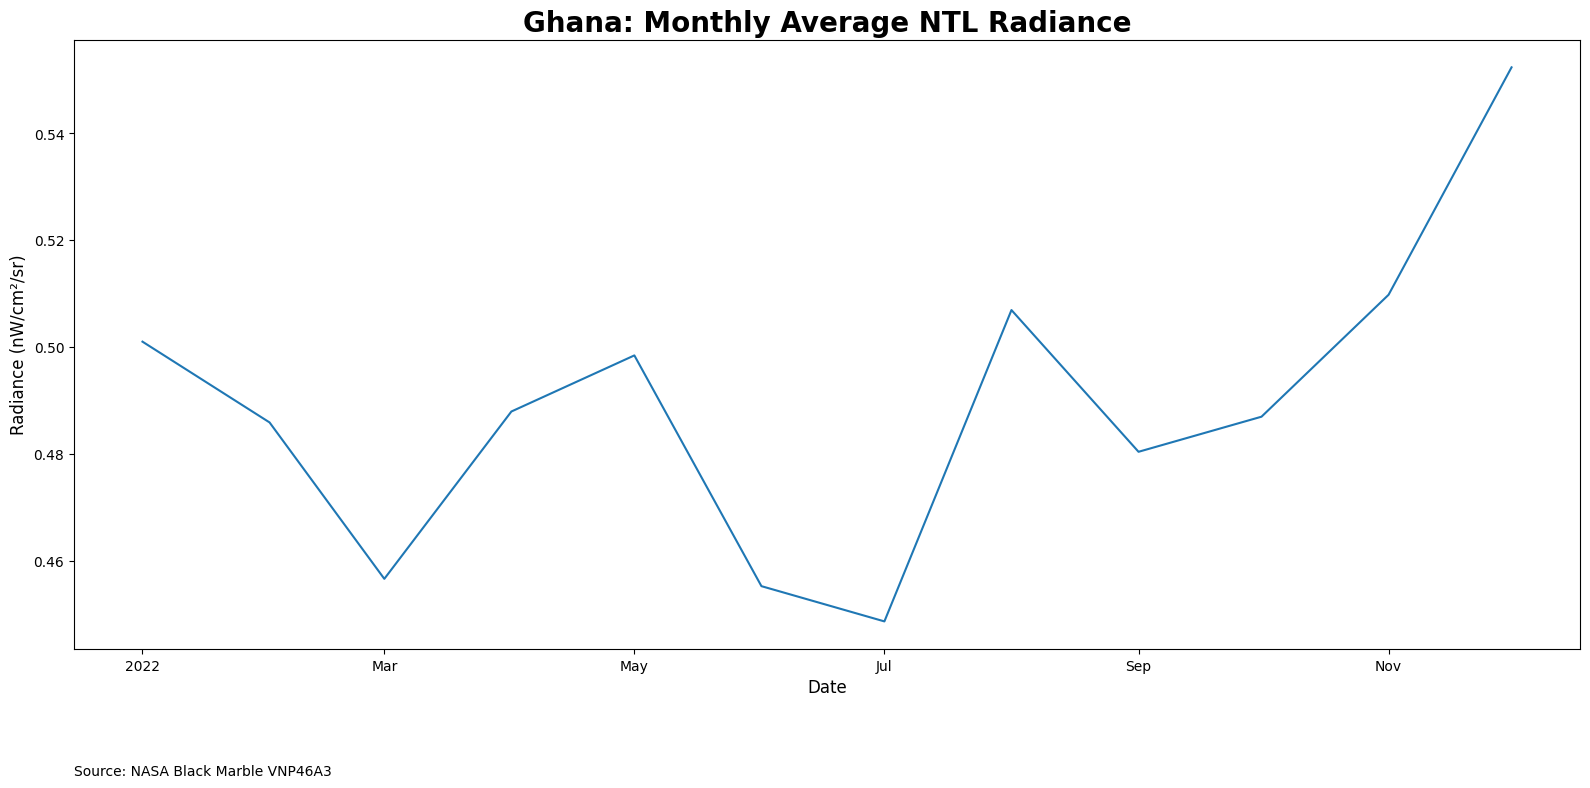

In [17]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the mean NTL radiance over the dimensions x and y
r_monthly["NearNadir_Composite_Snow_Free"].mean(dim=["x", "y"]).plot(ax=ax)

# Add the data source text
ax.text(
    0,
    -0.2,
    "Source: NASA Black Marble VNP46A3",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)

# Set the title with appropriate fontsize
ax.set_title("Ghana: Monthly Average NTL Radiance", fontsize=20, weight="bold")

# Add labels to the axes
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Radiance (nW/cm²/sr)", fontsize=12)

# Adjust layout for better spacing
fig.tight_layout()

# Show the plot
plt.show()

```{figure} ../../images/favicon.ico
---
height: 0px
---
This figures describes the monthly average nighttime lights radiance data plotted over time. The data reflects fluctuations in radiance levels due to varying cloud cover, affecting the accuracy of the measurements
```

In [18]:
# Raster stack of yearly data
r_yearly = bm.raster(
    gdf,
    product_id="VNP46A4",
    date_range=pd.date_range("2019-01-01", "2022-01-01", freq="YS"),
)

OBTAINING MANIFEST...:   0%|          | 0/4 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading (186.8 MB)...:   0%|          | 0/16 [00:00<?, ?file/s]

[2025-06-10 20:57:01] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2021001.h17v07.001.2022094115525.h5


PROCESSING TASKS | Downloading (186.8 MB)...:   0%|          | 0/16 [00:00<?, ?file/s]

  0%|          | 0.00/14.5M [00:00<?, ?B/s]

  0%|          | 0.00/9.66M [00:00<?, ?B/s]

  0%|          | 0.00/13.2M [00:00<?, ?B/s]

  0%|          | 0.00/13.8M [00:00<?, ?B/s]

[2025-06-10 20:57:02] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2021001.h18v08.001.2022094115509.h5


  0%|          | 0.00/9.68M [00:00<?, ?B/s]

  0%|          | 0.00/9.55M [00:00<?, ?B/s]

  0%|          | 0.00/8.98M [00:00<?, ?B/s]

[2025-06-10 20:57:03] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2021001.h17v08.001.2022094115514.h5


  0%|          | 0.00/9.18M [00:00<?, ?B/s]

  0%|          | 0.00/14.6M [00:00<?, ?B/s]

  0%|          | 0.00/9.68M [00:00<?, ?B/s]

  0%|          | 0.00/13.8M [00:00<?, ?B/s]

[2025-06-10 20:57:04] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2021001.h18v07.001.2022094115526.h5
[2025-06-10 20:57:10] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2022001.h18v07.001.2023081223927.h5


  0%|          | 0.00/13.4M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading (186.8 MB)...:   0%|          | 0/16 [00:00<?, ?file/s]

COLLATING TILES | Processing...:   0%|          | 0/4 [00:00<?, ?date/s]

In [19]:
r_yearly

<xarray.Dataset> Size: 53MB
Dimensions:                        (x: 1071, y: 1544, time: 4)
Coordinates:
  * x                              (x) float64 9kB -3.26 -3.256 ... 1.194 1.198
  * y                              (y) float64 12kB 11.17 11.17 ... 4.748 4.744
  * time                           (time) datetime64[ns] 32B 2019-01-01 ... 2...
Data variables:
    NearNadir_Composite_Snow_Free  (time, y, x) float64 53MB nan nan ... nan nan
Attributes: (12/40)
    AlgorithmType:                     b'SCI'
    AlgorithmVersion:                  b'NPP_PR46A3 2.0.0'
    Conventions:                       b'CF-1.6'
    DataResolution:                    b'15 arc second'
    DayNightFlag:                      b'Night'
    HorizontalTileNumber:              b'17'
    ...                                ...
    NorthBoundingCoord:                20.0
    publisher_email:                   b'modis-ops@lists.nasa.gov'
    publisher_name:                    b'LAADS'
    publisher_url:                     b'https://ladsweb.modaps.eosdis.nasa.gov'
    SouthBoundingCoord:                10.0
    WestBoundingCoord:                 -10.0

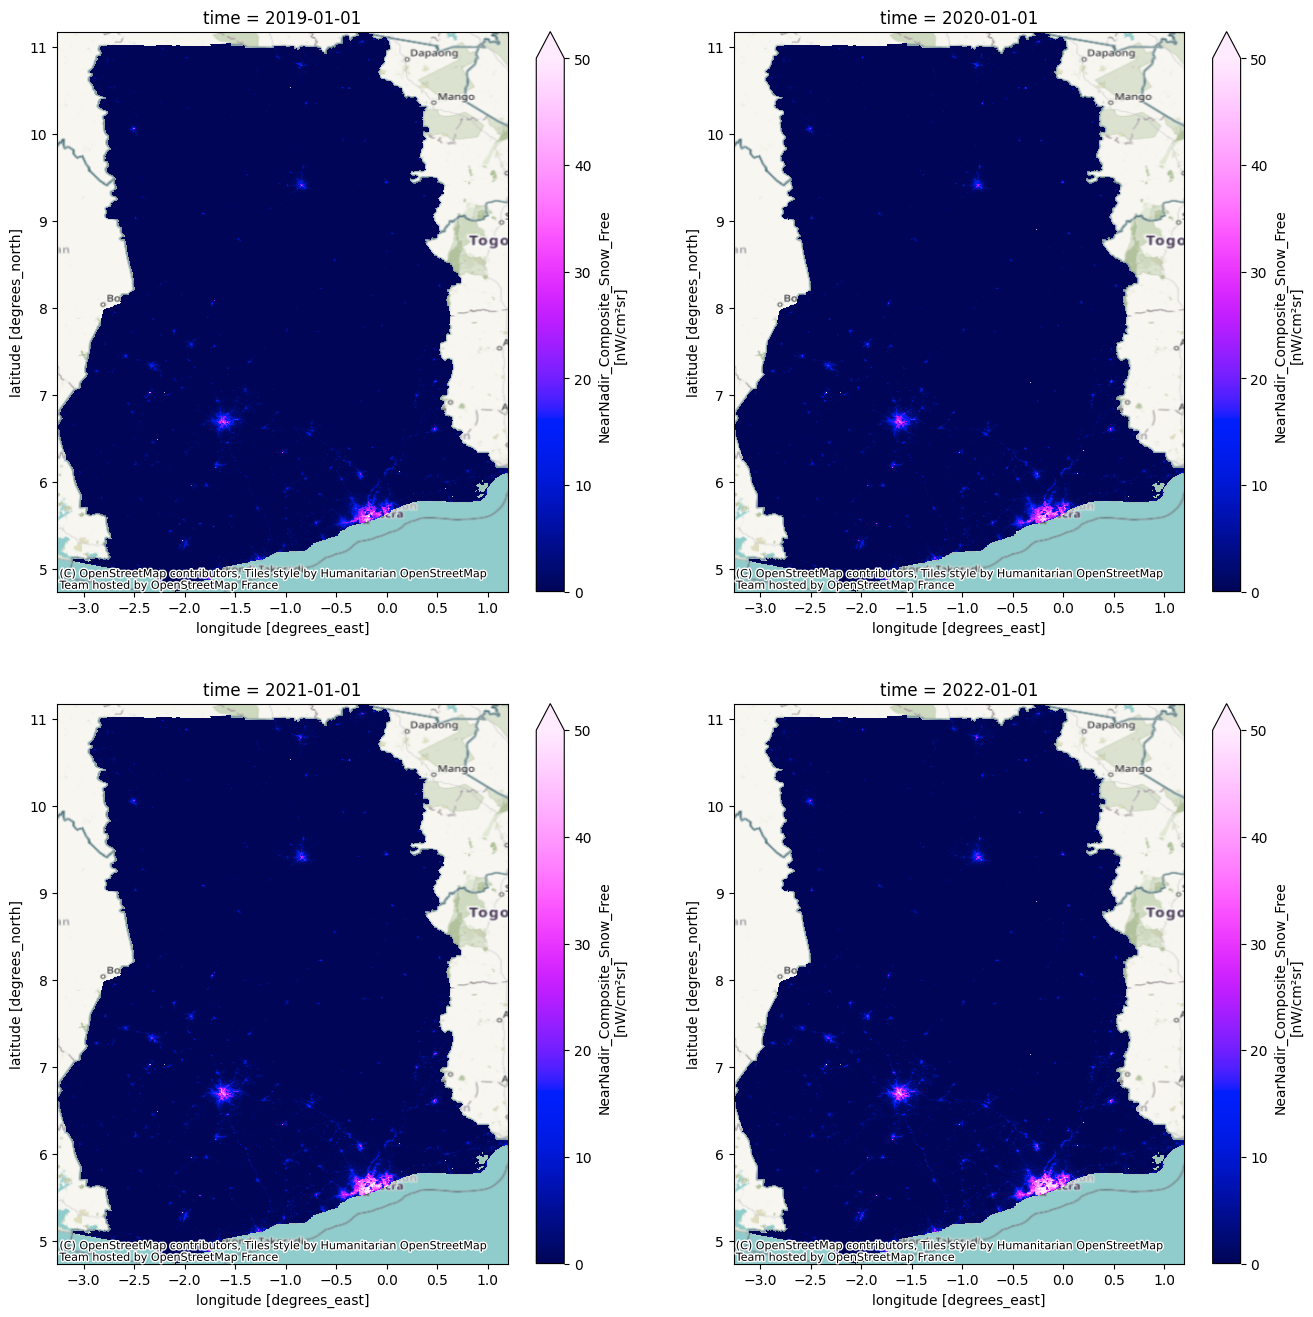

In [20]:
# Set up the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

for i, t in enumerate(r_yearly["time"]):
    row = i // 2
    col = i % 2
    ax = axs[row, col]

    r_yearly["NearNadir_Composite_Snow_Free"].sel(time=t).plot.pcolormesh(
        ax=ax,
        cmap=cc.cm.bmw,
        robust=True,
        vmax=50,
    )
    cx.add_basemap(ax, crs=gdf.crs.to_string())

plt.show()

```{figure} ../../images/favicon.ico
---
height: 0px
---
Temporal variation of `NearNadir_Composite_Snow_Free` mapped over multiple years. Each subplot represents a different time period overlaid with a basemap.
```

### Visualizing difference in radiance year over year

Lastly, we calculate the increase/decrease in nighttime lights radiance levels.

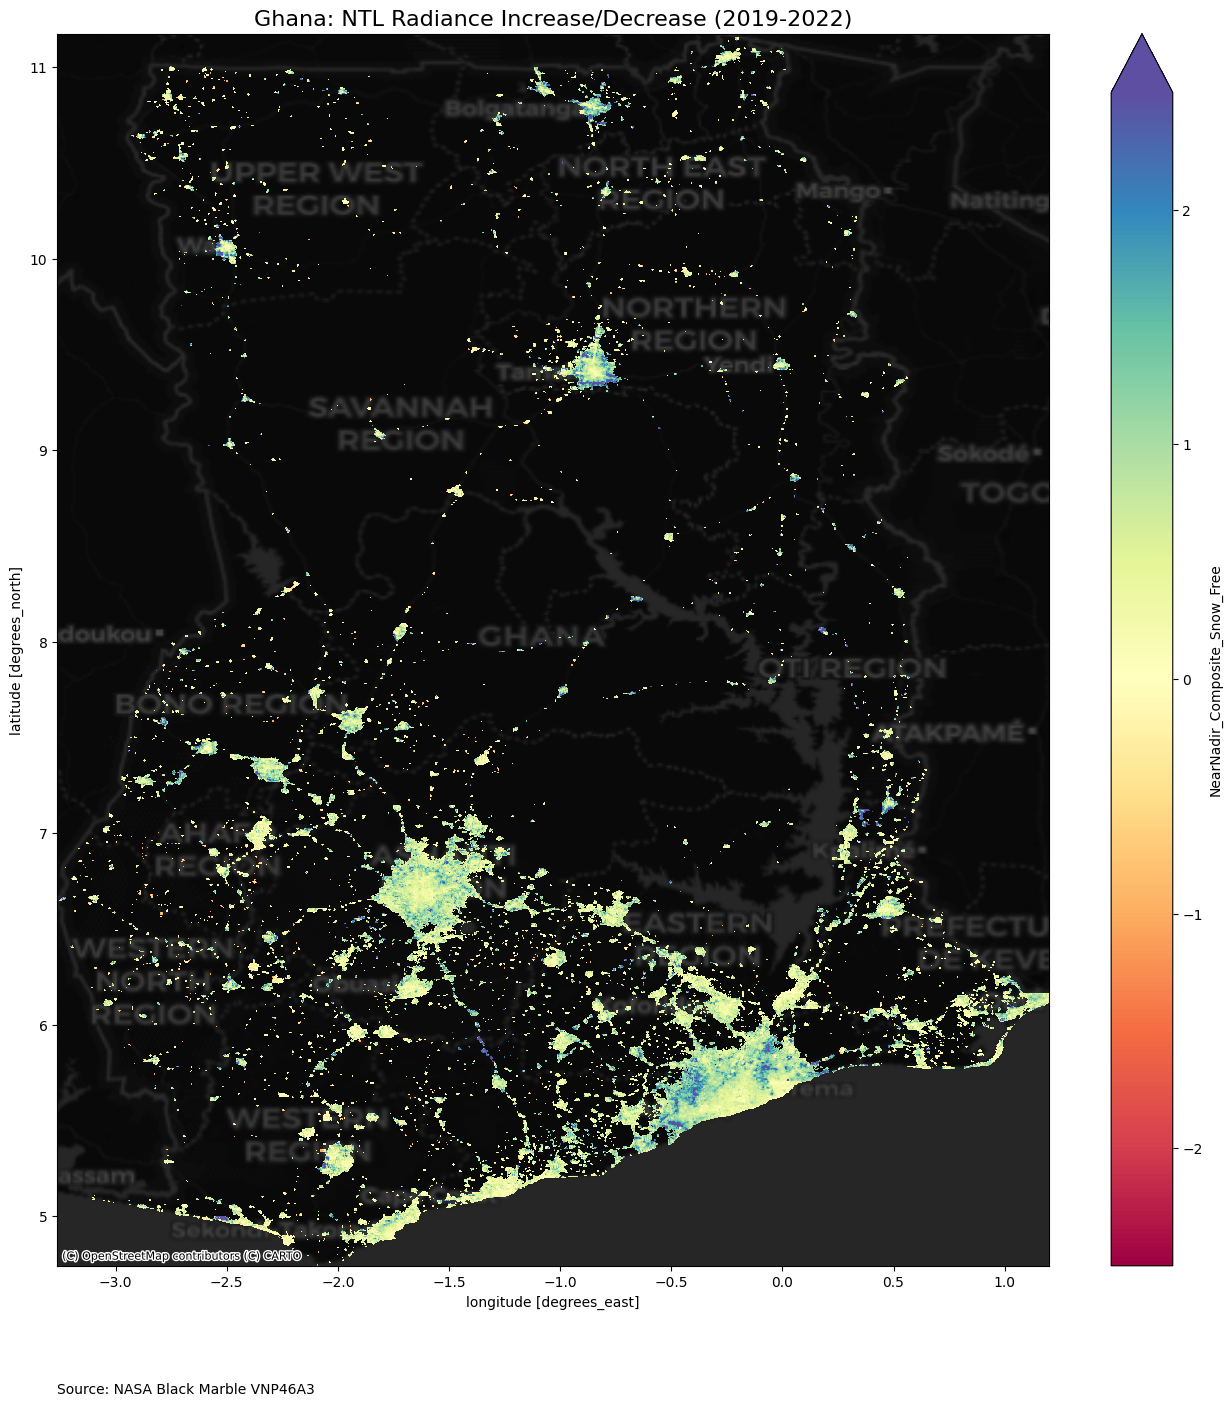

In [21]:
fig, ax = plt.subplots(figsize=(16, 16))

delta = (
    (
        (
            r_yearly["NearNadir_Composite_Snow_Free"].sel(time="2022-01-01")
            - r_yearly["NearNadir_Composite_Snow_Free"].sel(time="2019-01-01")
        )
        / r_yearly["NearNadir_Composite_Snow_Free"].sel(time="2019-01-01")
    )
    # .drop("time")
    .plot.pcolormesh(ax=ax, cmap="Spectral", robust=True)
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.DarkMatter)

ax.text(
    0,
    -0.1,
    "Source: NASA Black Marble VNP46A3",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)
ax.set_title("Ghana: NTL Radiance Increase/Decrease (2019-2022)", fontsize=16);

```{figure} ../../images/favicon.ico
---
height: 0px
---
This figure displays the percentage change in radiance for Ghana between 2019 and 2022. The data, sourced from NASA's Black Marble VNP46A3 product is visualized with basemap.
```

### Compute trends on nighttime lights over time

In this section, we use the `bm_extract` function to observe treends in nighttime lights over time. The `bm_extract` function leverages the [rasterstats](https://pythonhosted.org/rasterstats/) package to aggregate nighttime lights data to polygons. In the following example, we show trends in annual nighttime lights data across Ghana's first-administrative divisions.

In [25]:
VNP46A4 = bm.extract(
    gdf,
    "VNP46A4",
    pd.date_range("2012-01-01", "2023-01-01", freq="YS"),
)

OBTAINING MANIFEST...:   0%|          | 0/4 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading (558.1 MB)...:   0%|          | 0/48 [00:00<?, ?file/s]

PROCESSING TASKS | Downloading (558.1 MB)...:   0%|          | 0/48 [00:00<?, ?file/s]

  0%|          | 0.00/13.5M [00:00<?, ?B/s]

  0%|          | 0.00/14.2M [00:00<?, ?B/s]

  0%|          | 0.00/14.1M [00:00<?, ?B/s]

  0%|          | 0.00/13.7M [00:00<?, ?B/s]

  0%|          | 0.00/13.7M [00:00<?, ?B/s]

  0%|          | 0.00/13.9M [00:00<?, ?B/s]

  0%|          | 0.00/14.9M [00:00<?, ?B/s]

[2025-06-10 20:58:05] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2019001.h18v07.001.2021118150131.h5
[2025-06-10 20:58:05] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2020001.h18v07.001.2021118145831.h5
[2025-06-10 20:58:05] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2021001.h18v07.001.2022094115526.h5
[2025-06-10 20:58:05] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2022001.h18v07.001.2023081223927.h5


  0%|          | 0.00/14.2M [00:00<?, ?B/s]

  0%|          | 0.00/13.1M [00:00<?, ?B/s]

  0%|          | 0.00/13.7M [00:00<?, ?B/s]

  0%|          | 0.00/12.9M [00:00<?, ?B/s]

  0%|          | 0.00/13.3M [00:00<?, ?B/s]

  0%|          | 0.00/14.2M [00:00<?, ?B/s]

  0%|          | 0.00/13.3M [00:00<?, ?B/s]

[2025-06-10 20:58:09] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2019001.h17v07.001.2021118145702.h5
[2025-06-10 20:58:09] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2020001.h17v07.001.2021118145227.h5
[2025-06-10 20:58:09] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2021001.h17v07.001.2022094115525.h5
[2025-06-10 20:58:09] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2022001.h17v07.001.2023081124022.h5


  0%|          | 0.00/11.7M [00:00<?, ?B/s]

  0%|          | 0.00/9.63M [00:00<?, ?B/s]

  0%|          | 0.00/14.3M [00:00<?, ?B/s]

  0%|          | 0.00/9.85M [00:00<?, ?B/s]

  0%|          | 0.00/9.68M [00:00<?, ?B/s]

[2025-06-10 20:58:12] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2012001.h17v07.001.2021124115841.h5


  0%|          | 0.00/9.38M [00:00<?, ?B/s]

  0%|          | 0.00/9.42M [00:00<?, ?B/s]

[2025-06-10 20:58:12] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2019001.h18v08.001.2021118150218.h5
[2025-06-10 20:58:12] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2020001.h18v08.001.2021118145220.h5
[2025-06-10 20:58:12] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2021001.h18v08.001.2022094115509.h5
[2025-06-10 20:58:12] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2022001.h18v08.001.2023082112122.h5


  0%|          | 0.00/9.77M [00:00<?, ?B/s]

  0%|          | 0.00/10.3M [00:00<?, ?B/s]

  0%|          | 0.00/10.6M [00:00<?, ?B/s]

  0%|          | 0.00/8.24M [00:00<?, ?B/s]

  0%|          | 0.00/13.2M [00:00<?, ?B/s]

  0%|          | 0.00/8.17M [00:00<?, ?B/s]

  0%|          | 0.00/8.23M [00:00<?, ?B/s]

  0%|          | 0.00/8.34M [00:00<?, ?B/s]

[2025-06-10 20:58:15] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2019001.h17v08.001.2021118144835.h5
[2025-06-10 20:58:15] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2020001.h17v08.001.2021118145054.h5
[2025-06-10 20:58:15] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2021001.h17v08.001.2022094115514.h5
[2025-06-10 20:58:15] [INFO] [download]: File already exists, reusing: /private/var/folders/lb/68gqsbvn171cckt3kdl3d5nr0000gn/T/tmpm6kom2ta/VNP46A4.A2022001.h17v08.001.2023081124059.h5


  0%|          | 0.00/8.52M [00:00<?, ?B/s]

  0%|          | 0.00/8.84M [00:00<?, ?B/s]

  0%|          | 0.00/10.4M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading (558.1 MB)...:   0%|          | 0/48 [00:00<?, ?file/s]

COLLATING TILES | Processing...:   0%|          | 0/12 [00:00<?, ?date/s]

In [26]:
p = figure(
    title="Ghana Regions: Annual Average Nighttime Lights Radiance",
    width=760,
    height=600,
    x_axis_label="Year",
    x_axis_type="datetime",
    y_axis_type="log",
    y_axis_label="NTL Radiance",
    tools="pan,wheel_zoom,box_zoom,reset,save,box_select",
)
p.add_layout(
    Title(
        text=f"Source: NASA Black Marble. Creation date: {datetime.datetime.today().strftime('%d %B %Y')}.",
        text_font_size="10pt",
        text_font_style="italic",
    ),
    "below",
)
p.add_tools(
    HoverTool(
        tooltips=[
            ("Year", "@x{%Y}"),
            ("Radiance", "@y{0.00}"),
        ],
        formatters={"@x": "datetime"},
    )
)

data = VNP46A4.pivot_table(
    index="date", columns=["NAME_1"], values=["ntl_mean"], aggfunc="mean"
)

for column, color in zip(data.columns, cc.glasbey):
    r = p.line(
        data.index,
        data[column],
        legend_label=column[1],
        line_color=color,
        line_dash="dotdash",
        line_width=2,
    )

p.legend.click_policy = "hide"
p.title.text_font_size = "16pt"

p.add_layout(p.legend[0], "right")

output_notebook()
show(p)

Loading BokehJS ...

```{figure} ../../images/favicon.ico
---
height: 0px
---
This figure illustrates the trend in nighttime lights radiance across Ghana over the period from 2012 to 2023. The X-axis represents the years from 2012 to 2023, while the Y-axis measures the radiance in nanowatts per square centimeter per steradian (nW/cm²/sr). The data highlights changes in light intensity, which can be indicative of economic activity, urbanization, and infrastructure development. Data source: NASA Black Marble VNP46A4 retrieved with [BlackMarblePy](https://worldbank.github.io/blackmarblepy).
```

### Downloading and Storing Black Marble data

In this section, we provide a guide on using [BlackMarblePy](https://worldbank.github.io/blackmarblepy) to download [NASA Black Marble](https://blackmarble.gsfc.nasa.gov) data and save it to a specified local directory. You can use the `output_directory` parameter to designate the directory for saving the files. By default, files that have already been downloaded will not be re-downloaded in subsequent executions.

In [ ]:
BlackMarble(
    output_directory="data/",  # Save files to local directory
    output_skip_if_exists=True,  # Set to skip if exists
).raster(
    gdf,
    product_id="VNP46A4",
    date_range=pd.date_range("2022-01-01", "2022-01-01", freq="YS"),
)

Alternatively, set `output_skip_if_exists=False` to force the redownload of files from NASA.

## References 

{cite:empty}`ROMAN2018113`
{cite:empty}`blackmarblepy`

```{bibliography}
:filter: docname in docnames
:style: plain
```